# Modelos con SMOTE

In [ ]:
import pandas as pd
import numpy as np
import random
from itertools import product
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.neighbors import KernelDensity
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import pearsonr
from sklearn.feature_selection import f_classif
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
X = pd.read_csv("../Data/X.csv",delimiter=",")
y = pd.read_csv("../Data/Y.csv",delimiter=",")

In [ ]:
def plot_class_histogram(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(8, 6))
    plt.bar(unique_classes, class_counts)
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Histogram of Classes with SMOTE')
    plt.show()

In [ ]:
y.shape

(9649, 1)

In [ ]:
X.shape

(9649, 15)

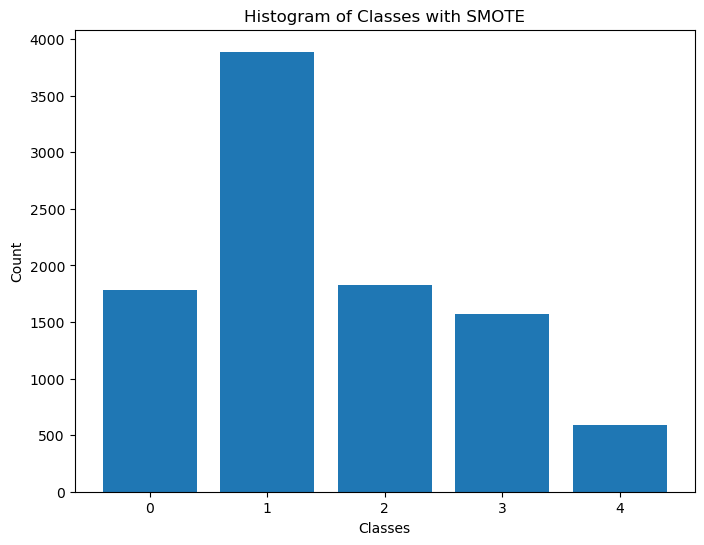

In [ ]:
plot_class_histogram(y)

### Aplicando SMOTE

In [ ]:
def apply_smote(X, y):
    smote = SMOTE(sampling_strategy='auto')
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [ ]:
X_smote,y_smote = apply_smote(X,y)

In [ ]:
X_smote.shape

(19445, 15)

In [ ]:
y_smote.shape

(19445, 1)

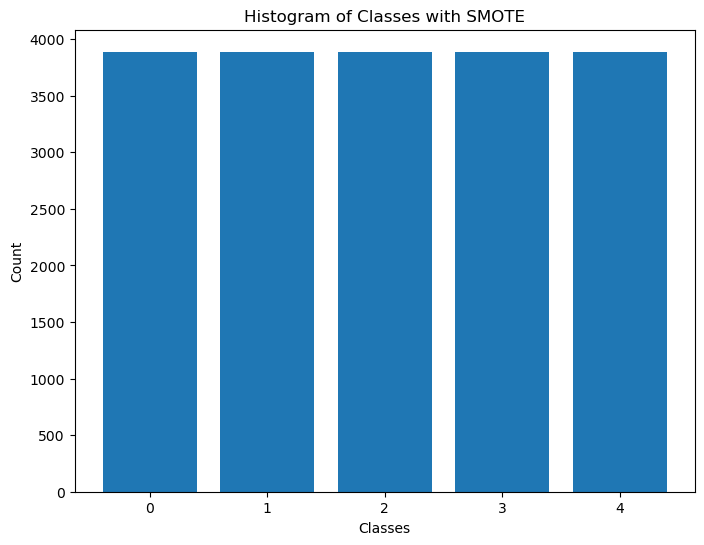

In [ ]:
plot_class_histogram(y_smote)

### Análisis de correlación y del índice de Fisher

In [ ]:
def feature_analysis(X, y):
    if isinstance(X, pd.DataFrame):
        X = X.values  # Convertir DataFrame a matriz NumPy

    num_features = X.shape[1]

    # Medidas de correlación
    correlation_scores = []
    for i in range(num_features):
        correlation, _ = pearsonr(X[:, i], y)
        correlation_scores.append(correlation)

        
    # Índice de Fisher
    fisher_scores, _ = f_classif(X, y)

    # Ordenar características por medida de correlación
    #sorted_indices_corr = np.argsort(correlation_scores)[::-1]
    #sorted_corr_scores = np.array(correlation_scores)[sorted_indices_corr]
    corr_scores = correlation_scores
    indices_corr = list(range(len(correlation_scores)))
    sorted_corr = sorted(zip(indices_corr, correlation_scores))
    sorted_indices_corr,sorted_corr_scores = zip(*sorted_corr)
    
    # Ordenar características por índice de Fisher
    sorted_indices_fisher = np.argsort(fisher_scores)[::-1]
    sorted_fisher_scores = np.array(fisher_scores)[sorted_indices_fisher]

    # Imprimir resultados
    print("Análisis individual de características:")
    print("Características ordenadas por medida de correlación:")
    for i in range(num_features):
        print("Característica {}: Correlación: {:.4f}".format(int(sorted_indices_corr[i]), float(sorted_corr_scores[i])))

    print("\nCaracterísticas ordenadas por índice de Fisher:")
    for i in range(num_features):
        print("Característica {}: Índice de Fisher: {:.4f}".format(sorted_indices_fisher[i], sorted_fisher_scores[i]))

In [ ]:
feature_analysis(X,y)

Análisis individual de características:
Características ordenadas por medida de correlación:
Característica 0: Correlación: -0.3015
Característica 1: Correlación: 0.5561
Característica 2: Correlación: 0.1060
Característica 3: Correlación: -0.0996
Característica 4: Correlación: -0.4857
Característica 5: Correlación: 0.2137
Característica 6: Correlación: 0.0910
Característica 7: Correlación: 0.0172
Característica 8: Correlación: 0.5575
Característica 9: Correlación: 0.0018
Característica 10: Correlación: -0.1025
Característica 11: Correlación: -0.4827
Característica 12: Correlación: 0.1041
Característica 13: Correlación: -0.1041
Característica 14: Correlación: 0.1451

Características ordenadas por índice de Fisher:
Característica 1: Índice de Fisher: 10386.8303
Característica 8: Índice de Fisher: 10083.7828
Característica 4: Índice de Fisher: 3703.1109
Característica 11: Índice de Fisher: 3532.8719
Característica 2: Índice de Fisher: 1459.0961
Característica 5: Índice de Fisher: 721.5448

### Selección de caracteristicas por el método de búsqueda secuencial ascencente (Tipo filtro)

In [ ]:
def sequential_feature_selection(X, y, num_features):
    if isinstance(X, pd.DataFrame):
        X = X.values  # Convertir DataFrame a matriz NumPy
    
    selected_features = []  # Lista para almacenar las características seleccionadas
    remaining_features = list(range(X.shape[1]))  # Lista de índices de características restantes
    
    for _ in range(num_features):
        best_feature = None
        best_score = [-np.inf]
        
        for feature in remaining_features:
            # Seleccionar una característica candidata
            candidate_features = selected_features + [feature]
            X_subset = X[:, candidate_features]
            
            # Calcular el puntaje de la característica candidata
            score = np.ravel(mutual_info_classif(X_subset, y))
            
            # Actualizar la mejor característica y el mejor puntaje
            if score[0] > best_score[0]:
                best_feature = feature
                best_score = score
        
        # Agregar la mejor característica a la lista de características seleccionadas
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
    
    X_subset = X[:, selected_features]  # Obtener la matriz de datos con las características seleccionadas
    
    return selected_features, X_subset


In [ ]:
features, X_feaures = sequential_feature_selection(X_smote,y_smote,8)

In [ ]:
print("Caracteristicas seleccionadas: ",features)

Caracteristicas seleccionadas:  [1, 6, 2, 10, 0, 8, 11, 9]


In [ ]:
X_feaures.shape

(19445, 8)

### División de datos de entrenamiento y test

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X_smote, y_smote, test_size=0.1, stratify = y_smote, random_state = 42)

In [ ]:
kf = StratifiedShuffleSplit(n_splits=3, test_size=0.4,random_state=42)

for index_train, index_test in kf.split(X_train, y_train,):
    X_train_sm, X_val_sm = X_train.iloc[index_train], X_train.iloc[index_test]
    y_train_sm, y_val_sm = y_train.iloc[index_train], y_train.iloc[index_test]

X_train_sm = X_train_sm.values[:, features]
X_val_sm = X_val_sm.values[:, features]
y_train_sm = y_train_sm.values
y_val_sm = y_val_sm.values

### Estandarización de los datos

In [ ]:
def standardize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

In [ ]:
X_train_sm = standardize_data(X_train_sm)
X_val_sm = standardize_data(X_val_sm)

### Validación cruzada estratificada de K-Fold

In [ ]:
def experimentos(model_choose, params):
    results = []
    
    model_dict = {
        "Parzen": None,
        "QDA": QuadraticDiscriminantAnalysis(),
        "GBT": GradientBoostingClassifier(),
        "MLP": MLPClassifier(),
        "SVM": SVC()   
    }
    
    kf = KFold(n_splits=5)  # Número deseado de divisiones
    
    param_combinations = list(product(*params.values()))
    random.shuffle(param_combinations)
    
    for param_values in param_combinations[:5]:  # Tomar 4 combinaciones de parámetros aleatorias
        param = dict(zip(params.keys(), param_values))
        
        accuracy_values = []
        precision_values = []
        recall_values = []
        f1_values = []
        print("Entrenando con: ",param)
        for train, val in kf.split(X_train_sm, y_train_sm):
            if model_choose == "Parzen":
                bandwidth = random.choice(params["bandwidth"])
                kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_train_sm[train])
                log_densities = kde.score_samples(X_train_sm[val])
                densities = np.exp(log_densities)
                prediction = [int(round(den)) for den in densities]
                #prediction = parzen_window(X_train_sm[train], y_train_sm[train], X_train_sm[val],bandwidth)
            else:
                model = model_dict[model_choose].set_params(**param).fit(X_train_sm[train], y_train_sm[train])
                prediction = model.predict(X_train_sm[val])

            accuracy_values.append(accuracy_score(y_train_sm[val], prediction))
            precision_values.append(precision_score(y_train_sm[val], prediction, average='weighted'))
            recall_values.append(recall_score(y_train_sm[val], prediction, average='weighted'))
            f1_values.append(f1_score(y_train_sm[val], prediction, average='weighted'))
        
        result = {
            'Parameters': param,
            'Accuracy': np.mean(accuracy_values),
            'Precision': np.mean(precision_values),
            'Recall': np.mean(recall_values),
            'F1': np.mean(f1_values)
        }
        
        results.append(result)
    
    df_results = pd.DataFrame(results)
    return df_results


### Gradient Boosting Tree

In [ ]:
gbc_params = {'max_features' : ['auto', 'sqrt', 'log2'],
              'random_state' : [42],
              'n_estimators' : [20,50,100]}
pipe = experimentos("GBT",gbc_params)

Entrenando con:  {'max_features': 'sqrt', 'random_state': 42, 'n_estimators': 100}
Entrenando con:  {'max_features': 'auto', 'random_state': 42, 'n_estimators': 50}
Entrenando con:  {'max_features': 'log2', 'random_state': 42, 'n_estimators': 100}
Entrenando con:  {'max_features': 'auto', 'random_state': 42, 'n_estimators': 100}
Entrenando con:  {'max_features': 'auto', 'random_state': 42, 'n_estimators': 20}


In [ ]:
pipe

,Parameters,Accuracy,Precision,Recall,F1
0,"{'max_features': 'sqrt', 'random_state': 42, '...",0.919429,0.918328,0.919429,0.917305
1,"{'max_features': 'auto', 'random_state': 42, '...",0.919714,0.918862,0.919714,0.917322
2,"{'max_features': 'log2', 'random_state': 42, '...",0.923048,0.922076,0.923048,0.920994
3,"{'max_features': 'auto', 'random_state': 42, '...",0.928667,0.927866,0.928667,0.926843
4,"{'max_features': 'auto', 'random_state': 42, '...",0.900190,0.900635,0.900190,0.895152


### Redes neuronales artificiales

In [ ]:
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Tamaños de las capas ocultas
    'activation': ['relu', 'logistic'],  # Funciones de activación
    'alpha': [0.0001, 0.001, 0.01],  # Valores para el parámetro de regularización alpha
    'learning_rate': ['constant', 'adaptive'],  # Tasas de aprendizaje
}
experimentos("MLP",mlp_params)

Entrenando con:  {'hidden_layer_sizes': (50,), 'activation': 'logistic', 'alpha': 0.001, 'learning_rate': 'adaptive'}
Entrenando con:  {'hidden_layer_sizes': (100, 50), 'activation': 'logistic', 'alpha': 0.0001, 'learning_rate': 'constant'}
Entrenando con:  {'hidden_layer_sizes': (50,), 'activation': 'relu', 'alpha': 0.01, 'learning_rate': 'constant'}
Entrenando con:  {'hidden_layer_sizes': (100, 50), 'activation': 'logistic', 'alpha': 0.0001, 'learning_rate': 'adaptive'}
Entrenando con:  {'hidden_layer_sizes': (50, 50), 'activation': 'logistic', 'alpha': 0.001, 'learning_rate': 'constant'}


,Parameters,Accuracy,Precision,Recall,F1
0,"{'hidden_layer_sizes': (50,), 'activation': 'l...",0.866476,0.862401,0.866476,0.862171
1,"{'hidden_layer_sizes': (100, 50), 'activation'...",0.881143,0.878297,0.881143,0.878311
2,"{'hidden_layer_sizes': (50,), 'activation': 'r...",0.920762,0.920287,0.920762,0.918795
3,"{'hidden_layer_sizes': (100, 50), 'activation'...",0.883238,0.880014,0.883238,0.880376
4,"{'hidden_layer_sizes': (50, 50), 'activation':...",0.866667,0.862553,0.866667,0.862236


### Maquinas de soporte vectorial

In [ ]:
params_svm = {
    'C': [0.1, 1.0, 10.0],  # Valores para el parámetro de regularización C
    'kernel': ['linear', 'rbf'],  # Kernels a considerar
    'gamma': ['scale', 'auto'],  # Valores para el parámetro gamma
}

experimentos("SVM",params_svm)

Entrenando con:  {'C': 1.0, 'kernel': 'linear', 'gamma': 'scale'}
Entrenando con:  {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale'}
Entrenando con:  {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}
Entrenando con:  {'C': 10.0, 'kernel': 'linear', 'gamma': 'scale'}
Entrenando con:  {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto'}


,Parameters,Accuracy,Precision,Recall,F1
0,"{'C': 1.0, 'kernel': 'linear', 'gamma': 'scale'}",0.843143,0.842320,0.843143,0.841701
1,"{'C': 0.1, 'kernel': 'linear', 'gamma': 'scale'}",0.834952,0.833808,0.834952,0.832703
2,"{'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}",0.859905,0.856591,0.859905,0.854967
3,"{'C': 10.0, 'kernel': 'linear', 'gamma': 'scale'}",0.846857,0.846131,0.846857,0.845739
4,"{'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto'}",0.860190,0.856928,0.860190,0.855276
